> **Problem overview**

Long ago, in the distant, fragrant mists of time, there was a competition...

It was not just any competition. It was a competition that challenged mere mortals to model a 20,000x200 matrix of continuous variables using only 250 training samples... without overfitting. Data scientists ― including Kaggle's very own Will Cukierski ― competed by the hundreds. Legends were made. (Will took 5th place, and eventually ended up working at Kaggle!) People overfit like crazy. It was a Kaggle-y, data science-y madhouse.

So... we're doing it again.

This is the next logical step in the evolution of weird competitions. Once again we have 20,000 rows of continuous variables, and a mere handful of training samples. Once again, we challenge you not to overfit. Do your best, model without overfitting, and add, perhaps, to your own legend. In addition to bragging rights, the winner also gets swag. Enjoy!

Interesting article:
* https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

In [1]:
# import data manipulation library
import numpy as np
import pandas as pd

# import data visualization library
import matplotlib.pyplot as plt
import seaborn as sns

# import pystan model class
import pystan

# import sklearn data preprocessing
from sklearn.preprocessing import RobustScaler

# import sklearn model class
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# import sklearn model selection
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# import sklearn model evaluation classification metrics
from sklearn.metrics import accuracy_score, auc, classification_report, confusion_matrix, f1_score, fbeta_score, precision_recall_curve, precision_score, recall_score, roc_auc_score, roc_curve

> **Acquiring training and testing data**

We start by acquiring the training and testing datasets into Pandas DataFrames.

In [2]:
# acquiring training and testing data
df_train = pd.read_csv('../input/train.csv')
df_test = pd.read_csv('../input/test.csv')

In [3]:
# visualize head of the training data
df_train.head(n=5)

id  target      0      1      2  ...      295    296    297    298    299
0   0     1.0 -0.098  2.165  0.681  ...   -2.097  1.051 -0.414  1.038 -1.065
1   1     0.0  1.081 -0.973 -0.383  ...   -1.624 -0.458 -1.099 -0.936  0.973
2   2     1.0 -0.523 -0.089 -0.348  ...   -1.165 -1.544  0.004  0.800 -1.211
3   3     1.0  0.067 -0.021  0.392  ...    0.467 -0.562 -0.254 -0.533  0.238
4   4     1.0  2.347 -0.831  0.511  ...    1.378  1.246  1.478  0.428  0.253

[5 rows x 302 columns]

In [4]:
# visualize tail of the testing data
df_test.tail(n=5)

id      0      1      2  ...      296    297    298    299
19745  19995  1.069  0.517 -0.690  ...   -0.381 -0.748  1.567  1.165
19746  19996 -0.529  0.438  0.672  ...   -0.940 -1.457 -1.152  0.937
19747  19997 -0.554 -0.936 -1.427  ...   -0.375  1.546  0.759  0.519
19748  19998 -0.746  1.205  0.750  ...   -1.054  1.319 -0.181  0.689
19749  19999  0.736 -0.216 -0.110  ...    0.318 -0.268  0.133  0.826

[5 rows x 301 columns]

In [5]:
# combine training and testing dataframe
df_train['datatype'], df_test['datatype'] = 'training', 'testing'
df_test.insert(1, 'target', np.nan)
df_data = pd.concat([df_train, df_test], ignore_index=True)

> **Feature exploration, engineering and cleansing**

Here we generate descriptive statistics that summarize the central tendency, dispersion and shape of a dataset’s distribution together with exploring some data.

In [6]:
# countplot function plot - categorical variable (x-axis) vs. categorical variable (y-axis)
def countplot(x = None, y = None, data = None, ncols = 5, nrows = 3):
    fig, axes = plt.subplots(figsize=(4*ncols , 3*nrows), ncols=ncols, nrows=nrows)
    axes = axes.flatten()
    for i, v in enumerate(x): sns.countplot(x=v, hue=y, data=data, ax=axes[i])

In [7]:
# boxplot function plot - categorical variable (x-axis) vs. numerical variable (y-axis)
def boxplot(cat = None, num = None, data = None, ncols = 5, nrows = 3):
    fig, axes = plt.subplots(figsize=(4*ncols , 3*nrows), ncols=ncols, nrows=nrows)
    axes = axes.flatten()
    if type(cat) == list:
        for i, v in enumerate(cat): sns.boxplot(x=v, y=num, data=data, ax=axes[i])
    else:
        for i, v in enumerate(num): sns.boxplot(x=cat, y=v, data=data, ax=axes[i])

In [8]:
# swarmplot function plot - categorical variable (x-axis) vs. numerical variable (y-axis)
def swarmplot(cat = None, num = None, data = None, ncols = 5, nrows = 3):
    fig, axes = plt.subplots(figsize=(4*ncols , 3*nrows), ncols=ncols, nrows=nrows)
    axes = axes.flatten()
    if type(cat) == list:
        for i, v in enumerate(cat): sns.swarmplot(x=v, y=num, data=data, ax=axes[i])
    else:
        for i, v in enumerate(num): sns.swarmplot(x=cat, y=v, data=data, ax=axes[i])

In [9]:
# violinplot function plot - categorical variable (x-axis) vs. numerical variable (y-axis)
def violinplot(cat = None, num = None, data = None, ncols = 5, nrows = 3):
    fig, axes = plt.subplots(figsize=(4*ncols , 3*nrows), ncols=ncols, nrows=nrows)
    axes = axes.flatten()
    if type(cat) == list:
        for i, v in enumerate(cat): sns.violinplot(x=v, y=num, data=data, ax=axes[i])
    else:
        for i, v in enumerate(num): sns.violinplot(x=cat, y=v, data=data, ax=axes[i])

In [10]:
# scatterplot function plot - numerical variable (x-axis) vs. numerical variable (y-axis)
def scatterplot(x = None, y = None, data = None, ncols = 5, nrows = 3):
    fig, axes = plt.subplots(figsize=(4*ncols , 3*nrows), ncols=ncols, nrows=nrows)
    axes = axes.flatten()
    for i, xi in enumerate(x): sns.scatterplot(x=xi, y=y, data=data, ax=axes[i])

In [11]:
# describe training and testing data
df_data.describe(include='all')

id      target    ...              299  datatype
count   20000.000000  250.000000    ...     20000.000000     20000
unique           NaN         NaN    ...              NaN         2
top              NaN         NaN    ...              NaN   testing
freq             NaN         NaN    ...              NaN     19750
mean     9999.500000    0.640000    ...        -0.001543       NaN
std      5773.647028    0.480963    ...         1.000313       NaN
min         0.000000    0.000000    ...        -4.135000       NaN
25%      4999.750000    0.000000    ...        -0.677000       NaN
50%      9999.500000    1.000000    ...         0.005000       NaN
75%     14999.250000    1.000000    ...         0.675000       NaN
max     19999.000000    1.000000    ...         4.070000       NaN

[11 rows x 303 columns]

In [12]:
# convert dtypes numeric to object
col_convert = ['target']
df_data[col_convert] = df_data[col_convert].astype('object')

In [13]:
# list all features type number
col_number = df_data.select_dtypes(include=['number']).columns.tolist()
print('features type number:\n items %s\n length %d' %(col_number, len(col_number)))

# list all features type object
col_object = df_data.select_dtypes(include=['object']).columns.tolist()
print('features type object:\n items %s\n length %d' %(col_object, len(col_object)))

features type number:
 items ['id', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '15

In [14]:
# feature exploration: histogram of all numeric features
_ = df_data.hist(bins=20, figsize=(200, 150))

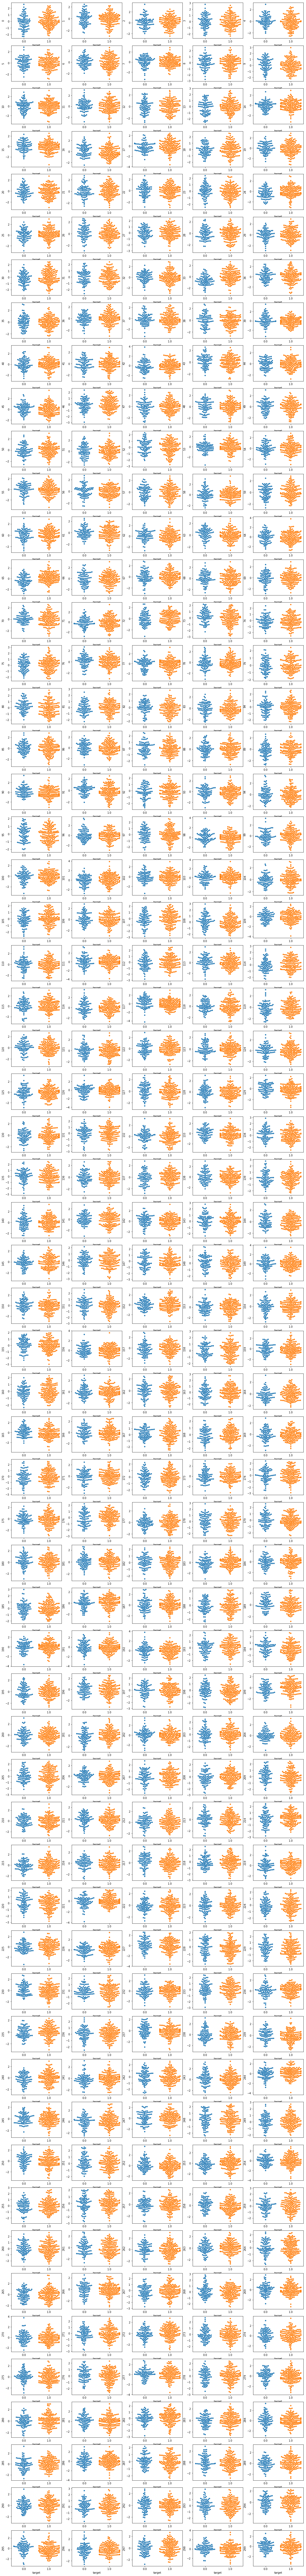

In [15]:
# feature exploration: target
col_number = df_data.select_dtypes(include=['number']).columns.drop(['id']).tolist()
swarmplot(cat='target', num=col_number, data=df_data, nrows=(len(col_number) - 1) // 5 + 1)

After extracting all features, it is required to convert category features to numerics features, a format suitable to feed into our Machine Learning models.

In [16]:
# feature extraction: target
df_data['target'] = df_data['target'].fillna(-1)

In [17]:
# convert category codes for data dataframe
df_data = pd.get_dummies(df_data, columns=['datatype'], drop_first=True)

In [18]:
# convert dtypes object to numeric for data dataframe
col_convert = ['target']
df_data[col_convert] = df_data[col_convert].astype(int)

In [19]:
# describe data dataframe
df_data.describe(include='all')

id        ...          datatype_training
count  20000.000000        ...               20000.000000
mean    9999.500000        ...                   0.012500
std     5773.647028        ...                   0.111105
min        0.000000        ...                   0.000000
25%     4999.750000        ...                   0.000000
50%     9999.500000        ...                   0.000000
75%    14999.250000        ...                   0.000000
max    19999.000000        ...                   1.000000

[8 rows x 303 columns]

In [20]:
# verify dtypes object
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Columns: 303 entries, id to datatype_training
dtypes: float64(300), int64(2), uint8(1)
memory usage: 46.1 MB


> **Analyze and identify patterns by visualizations**

Let us generate some correlation plots of the features to see how related one feature is to the next. To do so, we will utilize the Seaborn plotting package which allows us to plot very conveniently as follows.

The Pearson Correlation plot can tell us the correlation between features with one another. If there is no strongly correlated between features, this means that there isn't much redundant or superfluous data in our training data. This plot is also useful to determine which features are correlated to the observed value.

The pairplots is also useful to observe the distribution of the training data from one feature to the other.

The pivot table is also another useful method to observe the impact between features.

> **Model, predict and solve the problem**

Now, it is time to feed the features to Machine Learning models.

In [21]:
# select all features to evaluate the feature importances
x = df_data[df_data['datatype_training'] == 1].drop(['id', 'target', 'datatype_training'], axis=1)
y = df_data.loc[df_data['datatype_training'] == 1, 'target']

In [22]:
# set up lasso regression to find the feature importances
lassoreg = Lasso(alpha=1e-5).fit(x, y)
feat = pd.DataFrame(data=lassoreg.coef_, index=x.columns, columns=['feature_importances']).sort_values(['feature_importances'], ascending=False)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


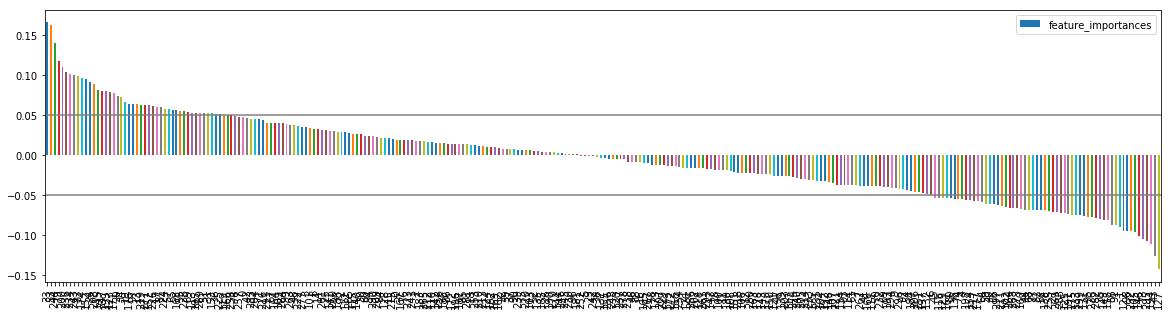

In [23]:
# plot the feature importances
feat[(feat['feature_importances'] < -1e-3) | (feat['feature_importances'] > 1e-3)].dropna().plot(y='feature_importances', figsize=(20, 5), kind='bar')
plt.axhline(-0.05, color="grey")
plt.axhline(0.05, color="grey")

In [24]:
# list feature importances
model_feat = feat[(feat['feature_importances'] < -0.05) | (feat['feature_importances'] > 0.05)].index

In [25]:
# select the important features
x = df_data.loc[df_data['datatype_training'] == 1, model_feat]
y = df_data.loc[df_data['datatype_training'] == 1, 'target']

In [26]:
# create scaler to the features
scaler = RobustScaler()
x = scaler.fit_transform(x)

In [27]:
# perform train-test (validate) split
x_train, x_validate, y_train, y_validate = train_test_split(x, y, random_state=58, test_size=0.25)

In [28]:
# linear regression model setup
model_linreg = LinearRegression()

# linear regression model fit
model_linreg.fit(x_train, y_train)

# linear regression model prediction
model_linreg_ypredict = model_linreg.predict(x_validate)

# linear regression model metrics
model_linreg_rocaucscore = roc_auc_score(y_validate, model_linreg_ypredict)
model_linreg_cvscores = cross_val_score(model_linreg, x, y, cv=20, scoring='roc_auc')
print('linear regression\n  roc auc score: %0.4f, cross validation score: %0.4f (+/- %0.4f)' %(model_linreg_rocaucscore, model_linreg_cvscores.mean(), 2 * model_linreg_cvscores.std()))

linear regression
  roc auc score: 0.9189, cross validation score: 0.9251 (+/- 0.1893)


With linear regression submission, the LB score is 0.629. It's seem overfitting.

In [29]:
# lasso regression model setup
model_lassoreg = Lasso(alpha=0.01)

# lasso regression model fit
model_lassoreg.fit(x_train, y_train)

# lasso regression model prediction
model_lassoreg_ypredict = model_lassoreg.predict(x_validate)

# lasso regression model metrics
model_lassoreg_rocaucscore = roc_auc_score(y_validate, model_lassoreg_ypredict)
model_lassoreg_cvscores = cross_val_score(model_lassoreg, x, y, cv=20, scoring='roc_auc')
print('lasso regression\n  roc auc score: %0.4f, cross validation score: %0.4f (+/- %0.4f)' %(model_lassoreg_rocaucscore, model_lassoreg_cvscores.mean(), 2 * model_lassoreg_cvscores.std()))

lasso regression
  roc auc score: 0.8895, cross validation score: 0.9023 (+/- 0.1662)


In [30]:
# specify the hyperparameter space
params = {
    'alpha': np.logspace(-4, -2, base=10, num=50),
}

# lasso regression grid search model setup
model_lassoreg_cv = GridSearchCV(model_lassoreg, params, iid=False, cv=5)

# lasso regression grid search model fit
model_lassoreg_cv.fit(x_train, y_train)

# lasso regression grid search model prediction
model_lassoreg_cv_ypredict = model_lassoreg_cv.predict(x_validate)

# lasso regression grid search model metrics
model_lassoreg_cv_rocaucscore = roc_auc_score(y_validate, model_lassoreg_cv_ypredict)
model_lassoreg_cv_cvscores = cross_val_score(model_lassoreg_cv, x, y, cv=20, scoring='roc_auc')
print('lasso regression grid search\n  roc auc score: %0.4f, cross validation score: %0.4f (+/- %0.4f)' %(model_lassoreg_cv_rocaucscore, model_lassoreg_cv_cvscores.mean(), 2 * model_lassoreg_cv_cvscores.std()))
print('  best parameters: %s' %model_lassoreg_cv.best_params_)

lasso regression grid search
  roc auc score: 0.8895, cross validation score: 0.9292 (+/- 0.1348)
  best parameters: {'alpha': 0.01}


With lasso regression submission, the LB score is 0.704. It's seem overfitting.

In [31]:
# ridge regression model setup
model_ridgereg = Ridge(alpha=35)

# ridge regression model fit
model_ridgereg.fit(x_train, y_train)

# ridge regression model prediction
model_ridgereg_ypredict = model_ridgereg.predict(x_validate)

# ridge regression model metrics
model_ridgereg_rocaucscore = roc_auc_score(y_validate, model_ridgereg_ypredict)
model_ridgereg_cvscores = cross_val_score(model_ridgereg, x, y, cv=20, scoring='roc_auc')
print('ridge regression\n  roc auc score: %0.4f, cross validation score: %0.4f (+/- %0.4f)' %(model_ridgereg_rocaucscore, model_ridgereg_cvscores.mean(), 2 * model_ridgereg_cvscores.std()))

ridge regression
  roc auc score: 0.9026, cross validation score: 0.9164 (+/- 0.1560)


In [32]:
# specify the hyperparameter space
params = {'alpha': np.logspace(-4, 4, base=10, num=50)}

# ridge regression grid search model setup
model_ridgereg_cv = GridSearchCV(model_ridgereg, params, iid=False, cv=5)

# ridge regression grid search model fit
model_ridgereg_cv.fit(x_train, y_train)

# ridge regression grid search model prediction
model_ridgereg_cv_ypredict = model_ridgereg_cv.predict(x_validate)

# ridge regression grid search model metrics
model_ridgereg_cv_rocaucscore = roc_auc_score(y_validate, model_ridgereg_cv_ypredict)
model_ridgereg_cv_cvscores = cross_val_score(model_ridgereg_cv, x, y, cv=20, scoring='roc_auc')
print('ridge regression grid search\n  roc auc score: %0.4f, cross validation score: %0.4f (+/- %0.4f)' %(model_ridgereg_cv_rocaucscore, model_ridgereg_cv_cvscores.mean(), 2 * model_ridgereg_cv_cvscores.std()))
print('  best parameters: %s' %model_ridgereg_cv.best_params_)

ridge regression grid search
  roc auc score: 0.9016, cross validation score: 0.9229 (+/- 0.1757)
  best parameters: {'alpha': 35.564803062231285}


With ridge regression submission, the LB score is 0.690. It's seem overfitting.

In [33]:
# elastic net regression model setup
model_elasticnetreg = ElasticNet(alpha=0.01, l1_ratio=0.9)

# elastic net regression model fit
model_elasticnetreg.fit(x_train, y_train)

# elastic net regression model prediction
model_elasticnetreg_ypredict = model_elasticnetreg.predict(x_validate)

# elastic net regression model metrics
model_elasticnetreg_rocaucscore = roc_auc_score(y_validate, model_elasticnetreg_ypredict)
model_elasticnetreg_cvscores = cross_val_score(model_elasticnetreg, x, y, cv=20, scoring='roc_auc')
print('elastic net regression\n  roc auc score: %0.4f, cross validation score: %0.4f (+/- %0.4f)' %(model_elasticnetreg_rocaucscore, model_elasticnetreg_cvscores.mean(), 2 * model_elasticnetreg_cvscores.std()))

elastic net regression
  roc auc score: 0.8925, cross validation score: 0.9023 (+/- 0.1626)


In [34]:
# specify the hyperparameter space
params = {'alpha': np.logspace(-4, -2, base=10, num=10),
          'l1_ratio': np.linspace(0.1, 0.9, num=5),
}

# elastic net regression grid search model setup
model_elasticnetreg_cv = GridSearchCV(model_elasticnetreg, params, iid=False, cv=5)

# elastic net regression grid search model fit
model_elasticnetreg_cv.fit(x_train, y_train)

# elastic net regression grid search model prediction
model_elasticnetreg_cv_ypredict = model_elasticnetreg_cv.predict(x_validate)

# elastic net regression grid search model metrics
model_elasticnetreg_cv_rocaucscore = roc_auc_score(y_validate, model_elasticnetreg_cv_ypredict)
model_elasticnetreg_cv_cvscores = cross_val_score(model_elasticnetreg_cv, x, y, cv=20, scoring='roc_auc')
print('elastic net regression grid search\n  roc auc score: %0.4f, cross validation score: %0.4f (+/- %0.4f)' %(model_elasticnetreg_cv_rocaucscore, model_elasticnetreg_cv_cvscores.mean(), 2 * model_elasticnetreg_cv_cvscores.std()))
print('  best parameters: %s' %model_elasticnetreg_cv.best_params_)

elastic net regression grid search
  roc auc score: 0.8925, cross validation score: 0.9266 (+/- 0.1348)
  best parameters: {'alpha': 0.01, 'l1_ratio': 0.9}


In [35]:
# kernel ridge regression model setup
model_kernelridgereg = KernelRidge(alpha=0.0001, degree=4, kernel='polynomial')

# kernel ridge regression model fit
model_kernelridgereg.fit(x_train, y_train)

# kernel ridge regression model prediction
model_kernelridgereg_ypredict = model_kernelridgereg.predict(x_validate)

# kernel ridge regression model metrics
model_kernelridgereg_rocaucscore = roc_auc_score(y_validate, model_kernelridgereg_ypredict)
model_kernelridgereg_cvscores = cross_val_score(model_kernelridgereg, x, y, cv=20, scoring='roc_auc')
print('kernel ridge regression\n  roc auc score: %0.4f, cross validation score: %0.4f (+/- %0.4f)' %(model_kernelridgereg_rocaucscore, model_kernelridgereg_cvscores.mean(), 2 * model_kernelridgereg_cvscores.std()))

kernel ridge regression
  roc auc score: 0.8773, cross validation score: 0.8987 (+/- 0.1609)


In [36]:
# specify the hyperparameter space
params = {'alpha': np.logspace(-4, -2, base=10, num=10),
          'degree': [1, 2, 3, 4, 5],
}

# kernel ridge regression grid search model setup
model_kernelridgereg_cv = GridSearchCV(model_kernelridgereg, params, iid=False, cv=5)

# kernel ridge regression grid search model fit
model_kernelridgereg_cv.fit(x_train, y_train)

# kernel ridge regression grid search model prediction
model_kernelridgereg_cv_ypredict = model_kernelridgereg_cv.predict(x_validate)

# kernel ridge regression grid search model metrics
model_kernelridgereg_cv_rocaucscore = roc_auc_score(y_validate, model_kernelridgereg_cv_ypredict)
model_kernelridgereg_cv_cvscores = cross_val_score(model_kernelridgereg_cv, x, y, cv=20, scoring='roc_auc')
print('kernel ridge regression grid search\n  roc auc score: %0.4f, cross validation score: %0.4f (+/- %0.4f)' %(model_kernelridgereg_cv_rocaucscore, model_kernelridgereg_cv_cvscores.mean(), 2 * model_kernelridgereg_cv_cvscores.std()))
print('  best parameters: %s' %model_kernelridgereg_cv.best_params_)

kernel ridge regression grid search
  roc auc score: 0.8773, cross validation score: 0.9101 (+/- 0.1576)
  best parameters: {'alpha': 0.0001, 'degree': 4}


In [37]:
# decision tree regression model setup
model_treereg = DecisionTreeRegressor(splitter='best', min_samples_split=5)

# decision tree regression model fit
model_treereg.fit(x_train, y_train)

# decision tree regression model prediction
model_treereg_ypredict = model_treereg.predict(x_validate)

# decision tree regression model metrics
model_treereg_rocaucscore = roc_auc_score(y_validate, model_treereg_ypredict)
model_treereg_cvscores = cross_val_score(model_treereg, x, y, cv=20, scoring='roc_auc')
print('decision tree regression\n  roc auc score: %0.4f, cross validation score: %0.4f (+/- %0.4f)' %(model_treereg_rocaucscore, model_treereg_cvscores.mean(), 2 * model_treereg_cvscores.std()))

decision tree regression
  roc auc score: 0.5943, cross validation score: 0.6222 (+/- 0.3471)


In [38]:
# random forest regression model setup
model_forestreg = RandomForestRegressor(n_estimators=100, min_samples_split=3, random_state=58)

# random forest regression model fit
model_forestreg.fit(x_train, y_train)

# random forest regression model prediction
model_forestreg_ypredict = model_forestreg.predict(x_validate)

# random forest regression model metrics
model_forestreg_rocaucscore = roc_auc_score(y_validate, model_forestreg_ypredict)
model_forestreg_cvscores = cross_val_score(model_forestreg, x, y, cv=20, scoring='roc_auc')
print('random forest regression\n  roc auc score: %0.4f, cross validation score: %0.4f (+/- %0.4f)' %(model_forestreg_rocaucscore, model_forestreg_cvscores.mean(), 2 * model_forestreg_cvscores.std()))

random forest regression
  roc auc score: 0.7059, cross validation score: 0.7472 (+/- 0.2836)


In [39]:
# stan model setup
model_code = """
    data {
        int N; // the number of training data
        int N2; // the number of testing data
        int K; // the number of features
        int y[N]; // the response variable
        matrix[N,K] X; // the training matrix
        matrix[N2,K] X_test; // the testing matrix
    }
    parameters {
        vector[K] alpha;
        real beta;
    }
    transformed parameters {
        vector[N] y_linear;
        y_linear = beta + X * alpha;
    }
    model {
        alpha ~ cauchy(0, 10); // cauchy distribution
        for (i in 1:K)
            alpha[i] ~ student_t(1, 0, 0.03); // student t distribution
        y ~ bernoulli_logit(y_linear); // bernoulli distribution, logit parameterization
    }
    generated quantities {
        vector[N2] y_pred;
        y_pred = beta + X_test * alpha;
    }
"""

model_data = {
    'N': 250,
    'N2': 19750,
    'K': 300,
    'y': df_data.loc[df_data['datatype_training'] == 1, 'target'],
    'X': df_data[df_data['datatype_training'] == 1].drop(['id', 'target', 'datatype_training'], axis=1),
    'X_test': df_data[df_data['datatype_training'] == 0].drop(['id', 'target', 'datatype_training'], axis=1),
}

model_stan = pystan.StanModel(model_code=model_code)

# stan model fit
model_stan_fitted = model_stan.sampling(data=model_data, seed=58)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e6fc318e60bec723400007e5f16e0f00 NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


With pystan bernoulli distribution, logit parameterization submission, the LB score is 0.859.

> **Supply or submit the results**

Our submission to the competition site Kaggle is ready. Any suggestions to improve our score are welcome.

In [40]:
# prepare testing data and compute the observed value
x_test = df_data[df_data['datatype_training'] == 0]
y_test = pd.DataFrame(np.mean(model_stan_fitted.extract(permuted=True)['y_pred'], axis=0),
                      columns=['target'], index=df_data.loc[df_data['datatype_training'] == 0, 'id'])

In [41]:
# summit the results
out = pd.DataFrame({'id': y_test.index, 'target': y_test['target']})
out.to_csv('submission.csv', index=False)